# Import Required Libraries
Import the necessary libraries, including pandas.

In [14]:
# Import Required Libraries
import pandas as pd

# Load Dataset
Load the dataset and display first few rows of the dataset

In [15]:
# Load Dataset
df = pd.read_csv('credit-risk-analysis-for-extending-bank-loans\\bankloans.csv')
df.head()  # Display the first few rows of the dataset

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [16]:
df.info()  # Display the information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


# Data Preprocessing

In [17]:
# Drop rows with missing values
df = df.dropna()
df.info()
# these are actually the rows without any label, they are not useful for our analysis though

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    int64  
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 54.7 KB


# Adaboost
We'll use cross validation to determine n_estimators

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define the features and the target variable
X = df.drop('default', axis=1)
y = df['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=AdaBoostClassifier(random_state=123, algorithm='SAMME'), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Cross-Validation Accuracy:', best_score)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8089285714285713


In [19]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict the target variable
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model
adaboost_accuracy = accuracy_score(y_test, y_pred)
print('Test Set Accuracy:', adaboost_accuracy)

Test Set Accuracy: 0.8214285714285714


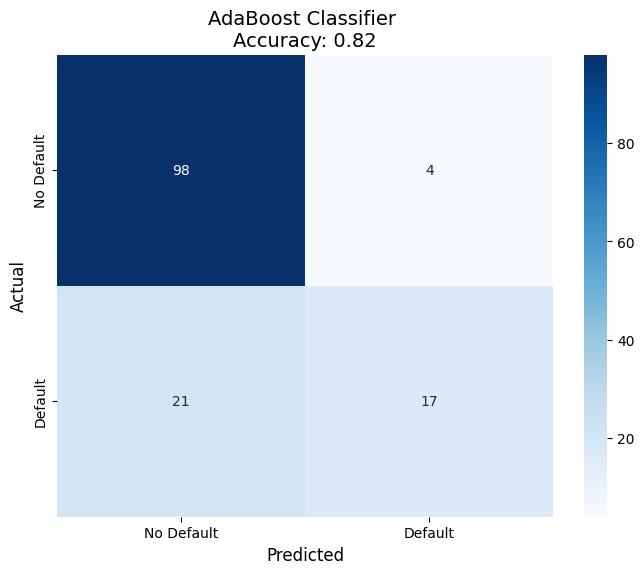

In [20]:
# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform the confusion matrix into a DataFrame
cm_df = pd.DataFrame(cm, index=['No Default', 'Default'], columns=['No Default', 'Default'])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('AdaBoost Classifier \nAccuracy: {:.2f}'.format(adaboost_accuracy), fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

Does Scaling even matter? (seemingly not)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# stratified split to ensure equal class distribution in the training and testing sets in case of imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Create a pipeline with scaling and AdaBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(random_state=123, algorithm='SAMME'))
])

# Updated parameter grid (now including the estimator in the pipeline)
param_grid = {
    'adaboost__n_estimators': [50, 100, 200, 300, 400, 500],
    'adaboost__learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Grid search with pipeline
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy'
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Cross-Validation Accuracy:', best_score)

# Final model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', test_accuracy)

Best Parameters: {'adaboost__learning_rate': 0.5, 'adaboost__n_estimators': 50}
Best Cross-Validation Accuracy: 0.7803571428571429
Test Accuracy: 0.8142857142857143


In [23]:
# Create a pipeline with scaling and AdaBoost using the best parameters
pipeline_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(n_estimators=best_params['adaboost__n_estimators'], 
                                    learning_rate=best_params['adaboost__learning_rate'], 
                                    random_state=123, 
                                    algorithm='SAMME'))
])

# Fit the pipeline with scaled data
pipeline_scaled.fit(X_train, y_train)

# Predict and evaluate the model with scaled data
y_pred_scaled = pipeline_scaled.predict(X_test)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print('Test Accuracy with Scaled Data:', accuracy_scaled)

# Create an AdaBoost model with the best parameters for unscaled data
model_unscaled = AdaBoostClassifier(n_estimators=best_params['adaboost__n_estimators'], 
                                    learning_rate=best_params['adaboost__learning_rate'], 
                                    random_state=123, 
                                    algorithm='SAMME')

# Fit the model with unscaled data
model_unscaled.fit(X_train, y_train)

# Predict and evaluate the model with unscaled data
y_pred_unscaled = model_unscaled.predict(X_test)
accuracy_unscaled = accuracy_score(y_test, y_pred_unscaled)
print('Test Accuracy with Unscaled Data:', accuracy_unscaled)

Test Accuracy with Scaled Data: 0.8142857142857143
Test Accuracy with Unscaled Data: 0.8142857142857143


How about using Recursive Feature Elimination with Cross-Validation? (seemingly not either)

In [27]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Define the AdaBoost classifier with fixed hyperparameters
adaboost = AdaBoostClassifier(
    random_state=123,
    algorithm='SAMME',
    n_estimators=50,
    learning_rate=0.5
)

# Create a pipeline with RFECV and AdaBoost
pipeline = Pipeline([
    ('rfe', RFECV(
        estimator=adaboost,
        step=1,
        cv=StratifiedKFold(5),
        scoring='accuracy'
    )),
    ('adaboost', adaboost)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Print selected features
selected_features = X_train.columns[pipeline.named_steps['rfe'].support_].tolist()
print('Selected features:', selected_features)

# Make predictions and evaluate
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('\nTest Accuracy:', test_accuracy)

Selected features: ['employ', 'address', 'debtinc', 'creddebt', 'othdebt']

Test Accuracy: 0.8142857142857143


# Linear SVC (Support Vector Classifier)

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Same train-test split from earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution (0 - No Default, 1 - Default)
print("Class Distribution:")
print(y_train.value_counts())

# Create a pipeline with scaling and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=123))
])

# Hyperparameter grid
# An approach with both GridSearchCV and RandomizedSearchCV
param_dist = {
    # 'svc__C': loguniform(1e-3, 1e3),  # Logarithmic scale for regularization
    # 'svc__gamma': loguniform(1e-4, 1e1),  # Kernel coefficient
    # 'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__C': [1e-3, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

# Stratified K-Fold for robust cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search for more efficient exploration
random_search = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=cv,
    scoring='balanced_accuracy',  # Better for imbalanced datasets
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best model details
print('\nBest Parameters:', random_search.best_params_)
print('Best Cross-Validation Score:', random_search.best_score_)

# Detailed performance evaluation
best_model = random_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='balanced_accuracy')
print('\nCross-Validation Scores:', cv_scores)
print('Mean CV Score:', cv_scores.mean())
print('Standard Deviation:', cv_scores.std())

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Test accuracy
svc_test_accuracy = accuracy_score(y_test, y_pred)
print('\nTest Accuracy:', svc_test_accuracy)

# Comprehensive evaluation
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# ROC AUC for binary classification
print('\nROC AUC Score:', roc_auc_score(y_test, y_pred_proba[:, 1]))

# Additional improvement strategies
def feature_importance_analysis(model, X):
    """
    Pseudo feature importance for linear kernels
    """
    if model.named_steps['svc'].kernel == 'linear':
        importances = np.abs(model.named_steps['svc'].coef_[0])
        feature_imp = pd.DataFrame({
            'feature': X.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        print("\nFeature Importances:")
        print(feature_imp)
    else:
        print("\nFeature importance not available for non-linear kernels")

# Analyze feature importances
feature_importance_analysis(best_model, X)

Class Distribution:
default
0.0    415
1.0    145
Name: count, dtype: int64
Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\antho\Anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best Parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 10}
Best Cross-Validation Score: 0.6513086830078937

Cross-Validation Scores: [0.6346074  0.62339011 0.68799335 0.6414624  0.66909015]
Mean CV Score: 0.6513086830078937
Standard Deviation: 0.023737205272851614

Test Accuracy: 0.8

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87       102
         1.0       0.75      0.39      0.52        38

    accuracy                           0.80       140
   macro avg       0.78      0.67      0.70       140
weighted avg       0.79      0.80      0.78       140


Confusion Matrix:
[[97  5]
 [23 15]]

ROC AUC Score: 0.7757997936016511

Feature importance not available for non-linear kernels


# Logistic Regression

Looking at other notebooks predicting this dataset, it seems that logistic regression does a great job, so let's try it!

In [58]:
from sklearn.linear_model import LogisticRegression

# Same train-test split from earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=123))
])

# Comprehensive parameter grid
param_grid = {
    # Regularization type
    'logistic__penalty': ['l1', 'l2'],
    
    # Regularization strength
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
    
    # Solver (matches penalty types)
    'logistic__solver': ['liblinear', 'saga'],
    
    # Class balancing
    'logistic__class_weight': [None, 'balanced'],
    
    # Multiclass strategy
    'logistic__multi_class': ['ovr']
}

# Stratified K-Fold for robust cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=cv,
    scoring='balanced_accuracy',  # Good for imbalanced datasets
    n_jobs=-1,  # Use all available cores
    verbose=1  # Show progress
)

# Fit the grid search
grid_search.fit(X, y)

# Best model details
print('Best Parameters:', grid_search.best_params_)
print('Best Cross-Validation Score:', grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Perform cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_test, y_test, cv=cv, scoring='balanced_accuracy')
print('\nCross-Validation Scores:', cv_scores)
print('Mean CV Score:', cv_scores.mean())
print('Standard Deviation:', cv_scores.std())

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Test accuracy
log_regression_test_accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', log_regression_test_accuracy)

# Comprehensive evaluation
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# ROC AUC for binary classification
print('\nROC AUC Score:', roc_auc_score(y_test, y_pred_proba[:, 1]))

# Feature coefficients (for interpretability)
if hasattr(best_model.named_steps['logistic'], 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.named_steps['logistic'].coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print('\nFeature Coefficients:')
    print(feature_importance)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'logistic__C': 1, 'logistic__class_weight': 'balanced', 'logistic__multi_class': 'ovr', 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}
Best Cross-Validation Score: 0.7753029635311189

Cross-Validation Scores: [0.925      0.825      0.775      0.76190476 0.80952381]
Mean CV Score: 0.8192857142857143
Standard Deviation: 0.05754521046243149
Test Accuracy: 0.8214285714285714

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87       102
         1.0       0.63      0.82      0.71        38

    accuracy                           0.82       140
   macro avg       0.78      0.82      0.79       140
weighted avg       0.84      0.82      0.83       140


Confusion Matrix:
[[84 18]
 [ 7 31]]

ROC AUC Score: 0.9120227038183695

Feature Coefficients:
    feature  coefficient
2    employ    -1.609991
6  creddebt     1.211750
3   address    -

c:\Users\antho\Anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\antho\Anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\antho\Anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\antho\Anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Let's compare their accuracies

AdaBoost Classifier Test Accuracy: 0.8214285714285714
SVC Test Accuracy: 0.8
Logistic Regression Test Accuracy: 0.8214285714285714


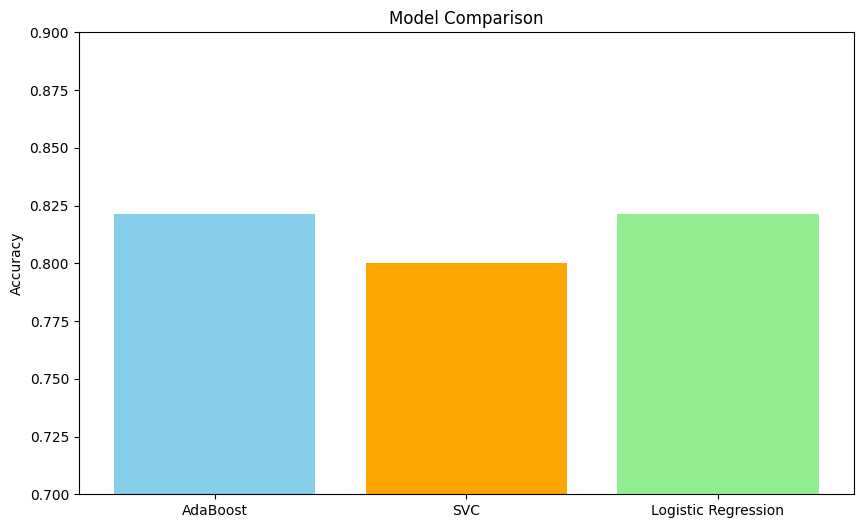

In [60]:
import matplotlib.pyplot as plt

print('AdaBoost Classifier Test Accuracy:', adaboost_accuracy)
print('SVC Test Accuracy:', svc_test_accuracy)
print('Logistic Regression Test Accuracy:', log_regression_test_accuracy)

# Create a bar plot
plt.figure(figsize=(10, 6))
models = ['AdaBoost', 'SVC', 'Logistic Regression']
accuracies = [adaboost_accuracy, svc_test_accuracy, log_regression_test_accuracy]
colors = ['skyblue', 'orange', 'lightgreen']

plt.bar(models, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.7, 0.9)
plt.show()